In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import seaborn as sns

In [12]:
import sys
mod = sys.modules[__name__]

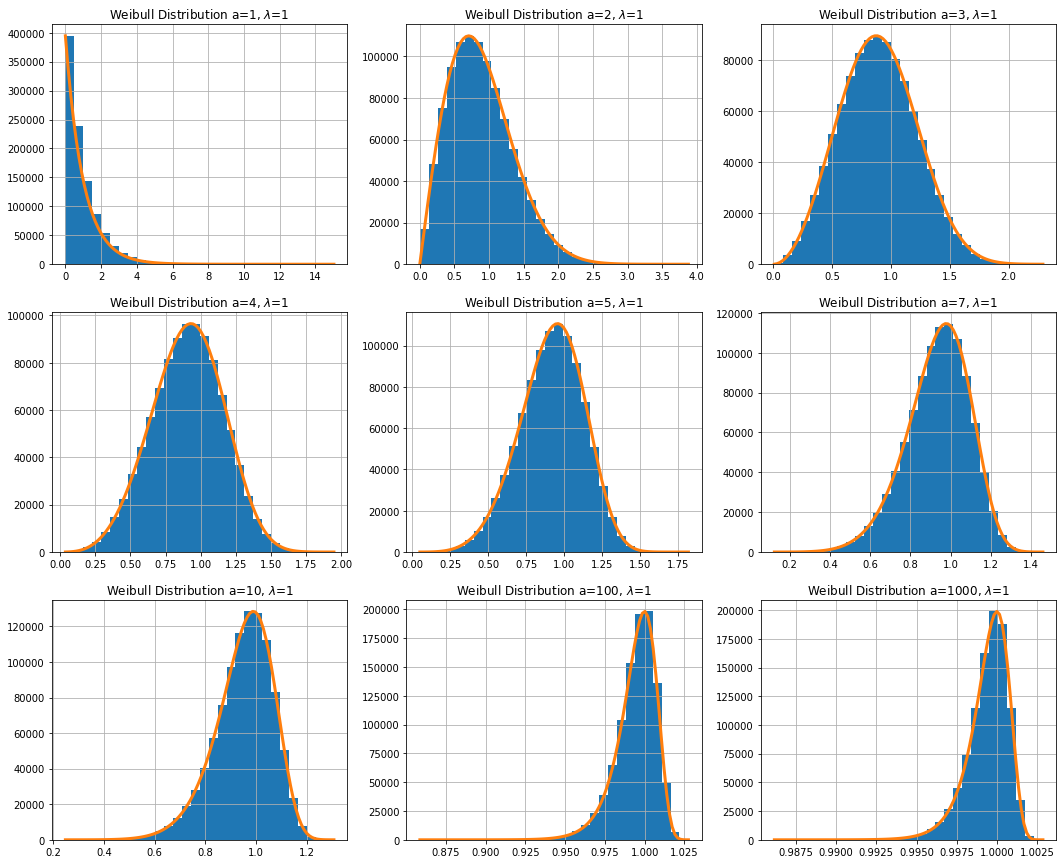

In [65]:
def weib(x, n, a):
    return (a / n) * (x / n) ** (a - 1) * np.exp(-(x / n) ** a)

fig = plt.figure(figsize=(18, 15), facecolor='w')
for ix, i in enumerate([1, 2, 3, 4, 5, 7, 10, 100, 1000]):
    setattr(mod, 'ax{}'.format(ix + 1), fig.add_subplot(3, 3, ix + 1))
    count, bins, ignored = getattr(mod, 'ax{}'.format(ix + 1)).hist(
            np.random.weibull(a=i, size=1000000), bins=30)
    x = np.linspace(bins[0], bins[-1], 100)
    scale = count.max() / weib(x, 1., i).max()
    getattr(mod, 'ax{}'.format(ix + 1)).plot(x, weib(x, 1., i) * scale, lw=3)
    getattr(mod, 'ax{}'.format(ix + 1)).grid(True)
    getattr(mod, 'ax{}'.format(ix + 1)).set_title(
        r'Weibull Distribution a={}, $\lambda$=1'.format(i))
plt.show()

# ragulpr - wtte-rnn

`data_generators.py`

```python
def generate_random_df(n_seqs=5,
                       max_seq_length=10,
                       unique_times=True,
                       starttimes_min=0,
                       starttimes_max=0):
    """Generates random dataframe for testing.
    For every sequence:
    1. generate a random seq_length from [1,`max_seq_length`]
    2. generate the number of observations in the sequence from [1,seq_length]
    3. randomly pick observation elapsed times from [1,`seq_length`]
    4. randomly pick a starttime [0,`starttimes_max`]
    5. Generate random data in the columns at these timesteps
    This means that the only thing we know about a sequence is that it's at maximum `max_seq_length`
    :param df: pandas dataframe with columns
      * `id`: integer
      * `t`: integer
      * `dt`: integer mimmicking a global event time
      * `t_ix`: integer contiguous user time count per id 0,1,2,..
      * `t_elapsed`: integer the time from starttime per id ex 0,1,10,..
      * `event`: 0 or 1
      * `int_column`: random data
      * `double_column`: dandom data
    :param int unique_times: whether there id,elapsed_time has only one obs. Default true
    :param int starttimes_min: integer to generate `dt` the absolute time
    :param int starttimes_max: integer to generate `dt` the absolute time
    :return df: A randomly generated dataframe.
    """

    seq_lengths = np.random.randint(max_seq_length, size=n_seqs) + 1
    id_list = []
    t_list = []
    dt_list = []

    if starttimes_min < starttimes_max:
        starttimes = np.sort(np.random.randint(
            low=starttimes_min, high=starttimes_max, size=n_seqs))
    else:
        starttimes = np.zeros(n_seqs)

    for s in xrange(n_seqs):
        # Each sequence consists of n_obs in the range 0-seq_lengths[s]
        n_obs = np.sort(np.random.choice(
            seq_lengths[s], 1, replace=False)) + 1

        # Each obs occurred at random times
        t_elapsed = np.sort(np.random.choice(
            seq_lengths[s], n_obs, replace=not unique_times))

        # there's always an obs at the assigned first and last timestep for
        # this seq
        if seq_lengths[s] - 1 not in t_elapsed:
            t_elapsed = np.append(t_elapsed, seq_lengths[s] - 1)
        if 0 not in t_elapsed:
            t_elapsed = np.append(t_elapsed, 0)

        t_elapsed = np.sort(t_elapsed)

        id_list.append(np.repeat(s, repeats=len(t_elapsed)))
        dt_list.append(starttimes[s] + t_elapsed)
        t_list.append(t_elapsed)

    # unlist to one array
    id_column = [item for sublist in id_list for item in sublist]
    dt_column = [item for sublist in dt_list for item in sublist]
    t_column = [item for sublist in t_list for item in sublist]
    del id_list, dt_list, t_list

    # do not assume row indicates event!
    event_column = np.random.randint(2, size=len(t_column))
    int_column = np.random.randint(low=-5, high=5, size=len(t_column)).astype(int)
    double_column = np.random.uniform(high=1, low=0, size=len(t_column))

    df = pd.DataFrame({'id': id_column,
                       'dt': dt_column,
                       't_elapsed': t_column,
                       'event': event_column,
                       'int_column': int_column,
                       'double_column': double_column
                       })

    df['t_ix'] = df.groupby(['id'])['t_elapsed'].rank(
        method='dense').astype(int) - 1
    df = df[['id', 'dt', 't_ix', 't_elapsed',
             'event', 'int_column', 'double_column']]
    df = df.reset_index(drop=True)

    return df
```

In [196]:
def generate_random_df(n_seqs=5,
                       max_seq_length=10,
                       unique_times=True,
                       starttimes_min=0,
                       starttimes_max=0):
    """Generates random dataframe for testing.
    For every sequence:
    1. generate a random seq_length from [1,`max_seq_length`]
    2. generate the number of observations in the sequence from [1,seq_length]
    3. randomly pick observation elapsed times from [1,`seq_length`]
    4. randomly pick a starttime [0,`starttimes_max`]
    5. Generate random data in the columns at these timesteps
    This means that the only thing we know about a sequence is that it's at maximum `max_seq_length`
    :param df: pandas dataframe with columns
      * `id`: integer
      * `t`: integer
      * `dt`: integer mimmicking a global event time
      * `t_ix`: integer contiguous user time count per id 0,1,2,..
      * `t_elapsed`: integer the time from starttime per id ex 0,1,10,..
      * `event`: 0 or 1
      * `int_column`: random data
      * `double_column`: dandom data
    :param int unique_times: whether there id,elapsed_time has only one obs. Default true
    :param int starttimes_min: integer to generate `dt` the absolute time
    :param int starttimes_max: integer to generate `dt` the absolute time
    :return df: A randomly generated dataframe.
    """

    seq_lengths = np.random.randint(max_seq_length, size=n_seqs) + 1
    id_list = []
    t_list = []
    dt_list = []

    if starttimes_min < starttimes_max:
        starttimes = np.sort(np.random.randint(
            low=starttimes_min, high=starttimes_max, size=n_seqs))
    else:
        starttimes = np.zeros(n_seqs)

    for s in xrange(n_seqs):
        # Each sequence consists of n_obs in the range 0-seq_lengths[s]
        n_obs = np.sort(np.random.choice(
            seq_lengths[s], 1, replace=False)) + 1

        # Each obs occurred at random times
        t_elapsed = np.sort(np.random.choice(
            seq_lengths[s], n_obs, replace=not unique_times))

        # there's always an obs at the assigned first and last timestep for
        # this seq
        if seq_lengths[s] - 1 not in t_elapsed:
            t_elapsed = np.append(t_elapsed, seq_lengths[s] - 1)
        if 0 not in t_elapsed:
            t_elapsed = np.append(t_elapsed, 0)

        t_elapsed = np.sort(t_elapsed)

        id_list.append(np.repeat(s, repeats=len(t_elapsed)))
        dt_list.append(starttimes[s] + t_elapsed)
        t_list.append(t_elapsed)

    # unlist to one array
    id_column = [item for sublist in id_list for item in sublist]
    dt_column = [item for sublist in dt_list for item in sublist]
    t_column = [item for sublist in t_list for item in sublist]
    del id_list, dt_list, t_list

    # do not assume row indicates event!
    event_column = np.random.randint(2, size=len(t_column))
    int_column = np.random.randint(low=-5, high=5, size=len(t_column)).astype(int)
    double_column = np.random.uniform(high=1, low=0, size=len(t_column))

    df = pd.DataFrame({'id': id_column,
                       'dt': dt_column,
                       't_elapsed': t_column,
                       'event': event_column,
                       'int_column': int_column,
                       'double_column': double_column
                       })

    df['t_ix'] = df.groupby(['id'])['t_elapsed'].rank(
        method='dense').astype(int) - 1
    df = df[['id', 'dt', 't_ix', 't_elapsed',
             'event', 'int_column', 'double_column']]
    df = df.reset_index(drop=True)

    return df

In [176]:
n_seqs = 5
max_seq_length = 10
unique_times = True
starttimes_min = 0
starttimes_max = 0

In [177]:
seq_lengths = np.random.randint(max_seq_length, size=n_seqs) + 1
id_list, t_list, dt_list = [], [], []
seq_lengths

array([ 1, 10,  7, 10,  8])

In [178]:
if starttimes_min < starttimes_max:
    starttimes = np.sort(np.random.randint(
            low=stattimes_min, high=starttimes_max, size=n_seqs))
else:
    starttimes = np.zeros(n_seqs)
starttimes

array([0., 0., 0., 0., 0.])

In [179]:
for s in range(n_seqs):
    # Each sequence consists of n_obs in the range 0-seq_lengths[s]
    n_obs = np.sort(np.random.choice(
        seq_lengths[s], 1, replace=False)) + 1
    
    # Each obs occurred at random times
    t_elapsed = np.sort(np.random.choice(
        seq_lengths[s], n_obs, replace=not unique_times))
    
    # there's always an obs at the assigned first and last timestep for
    # this seq
    if seq_lengths[s] - 1 not in t_elapsed:
        t_elapsed = np.append(t_elapsed, seq_lengths[s] - 1)
    if 0 not in t_elapsed:
        t_elapsed = np.append(t_elapsed, 0)
        
    t_elapsed = np.sort(t_elapsed)
    
    id_list.append(np.repeat(s, repeats=len(t_elapsed)))
    dt_list.append(starttimes[s] + t_elapsed)
    t_list.append(t_elapsed)

In [180]:
id_list

[array([0]),
 array([1, 1, 1]),
 array([2, 2, 2]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([4, 4, 4, 4, 4, 4, 4, 4])]

In [181]:
dt_list

[array([0.]),
 array([0., 2., 9.]),
 array([0., 4., 6.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0., 1., 2., 3., 4., 5., 6., 7.])]

In [182]:
t_list

[array([0]),
 array([0, 2, 9]),
 array([0, 4, 6]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7])]

In [183]:
# unlist to one array
id_column = [item for sublist in id_list for item in sublist]
dt_column = [item for sublist in dt_list for item in sublist]
t_column = [item for sublist in t_list for item in sublist]
del id_list, dt_list, t_list

In [184]:
# do not assume row indicated event!
event_column = np.random.randint(2, size=len(t_column))
int_column = np.random.randint(low=-5, high=5, size=len(t_column)).astype(int)
double_column = np.random.uniform(high=1, low=0, size=len(t_column))

print(event_column, end='\n\n')
print(int_column, end='\n\n')
print(double_column)

[1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1]

[-1  1  2 -1  3  3  1 -1  4  3 -4  4  1  4  0 -5 -3  2  2  4  0  4  1 -3
 -1]

[0.53227984 0.16913206 0.62753356 0.10404892 0.40595264 0.33686964
 0.92634926 0.63094603 0.72308495 0.77273233 0.66966751 0.8680086
 0.05227083 0.67222383 0.6409183  0.95940999 0.50528542 0.34125912
 0.34840479 0.34532813 0.66001811 0.16781471 0.47119663 0.38531419
 0.32738881]


In [185]:
df = pd.DataFrame(
    {'id' : id_column,
     'dt' : dt_column,
     't_elapsed' : t_column,
     'event' : event_column,
     'int_column' : int_column,
     'double_column' : double_column}
)

df

,id,dt,t_elapsed,event,int_column,double_column
0,0,0.0,0,1,-1,0.532280
1,1,0.0,0,0,1,0.169132
2,1,2.0,2,1,2,0.627534
3,1,9.0,9,0,-1,0.104049
4,2,0.0,0,1,3,0.405953
5,2,4.0,4,1,3,0.336870
6,2,6.0,6,1,1,0.926349
7,3,0.0,0,1,-1,0.630946
8,3,1.0,1,0,4,0.723085
9,3,2.0,2,0,3,0.772732


In [193]:
df['t_ix'] = df.groupby(['id'])['t_elapsed'].rank(
    method='dense').astype(int) - 1
df = df[['id', 'dt', 't_ix', 't_elapsed',
         'event', 'int_column', 'double_column']]
df = df.reset_index(drop=True)

In [194]:
df

,id,dt,t_ix,t_elapsed,event,int_column,double_column
0,0,0.0,0,0,1,-1,0.532280
1,1,0.0,0,0,0,1,0.169132
2,1,2.0,1,2,1,2,0.627534
3,1,9.0,2,9,0,-1,0.104049
4,2,0.0,0,0,1,3,0.405953
5,2,4.0,1,4,1,3,0.336870
6,2,6.0,2,6,1,1,0.926349
7,3,0.0,0,0,1,-1,0.630946
8,3,1.0,1,1,0,4,0.723085
9,3,2.0,2,2,0,3,0.772732


```python
def generate_weibull():
```

In [195]:
def generate_weibull(A, B, C, shape, discrete_time):
    """Generate Weibull random variables.
    Inputs can be scalar or broadcastable to `shape`.
    :param A: Generating alpha
    :param B: Generating beta
    :param C: Censoring time
    :return: list of `[W, Y, U]`
      * `W`: Actual TTE
      * `Y`: Censored TTE
      * `U`: non-censoring indicators
    :rtype: ndarray
    """
    W = np.sort(A * np.power(-np.log(np.random.uniform(0, 1, shape)), 1 / B))

    if discrete_time:
        C = np.floor(C)
        W = np.floor(W)

    U = np.less_equal(W, C) * 1.
    Y = np.minimum(W, C)
    return W, Y, U

`tte_util.py`

In [199]:
def roll_fun(x, size, fun=np.mean, reverse=False):
    """Like cumsum but with any function `fun`. 
    """
    y = np.copy(x)
    n = len(x)
    size = min(size, n)

    if size <= 1:
        return x

    for i in range(size):
        y[i] = fun(x[0:(i + 1)])
    for i in range(size, n):
        y[i] = fun(x[(i - size + 1):(i + 1)])
    return y

In [202]:
def carry_forward_if(x, is_true):
    """Locomote forward `x[i]` if `is_true[i]`.
        remain x untouched before first pos of truth.
        :param Array x: object whos elements are to carry forward
        :param Array is_true: same length as x containing true/false boolean.
        :return Array x: forwarded object
    """
    for i in range(len(x)):
        if is_true[i]:
            cargo = x[i]
        if cargo is not None:
            x[i] = cargo
    return x

In [212]:
def carry_backward_if(x, is_true):
    """Locomote backward `x[i]` if `is_true[i]`.
        remain x untouched after last pos of truth.
        :param Array x: object whos elements are to carry backward
        :param Array is_true: same length as x containing true/false boolean.
        :return Array x: backwarded object
    """
    for i in reversed(range(len(x))):
        if is_true[i]:
            cargo = x[i]
        if cargo is not None:
            x[i] = cargo
    return x

In [214]:
x = [1,2,3,4,5,6,7]
is_true = [True, False, False, True, True, True, False]

for i in reversed(range(len(x))):
    if is_true[i]:
        

5
4
3
0
